In [31]:
# import os
import torch
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import kagglehub
# import shutil

from torch import nn
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from torchinfo import summary
from torch.utils.data import DataLoader

from models.transLOB import TransLOB
from utils.fi2010_loader import Dataset_fi2010
# from models.transLOB_v2 import TransLOB
# from utils.preprocessing_v2 import create_windows, generate_labels, normalize_features, add_features
# from utils.training import train, validate
# from utils.loader import LOBDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [14]:
dataset_type='fi2010'
normalization = 'Zscore'
lighten = False # True
feature_size = 40

T = 100
k = 4
stock = [0, 1, 2, 3, 4]
train_test_ratio = 0.75
# auction = False
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

batch_size= 128
# epsilon= 1e-08
num_workers= 4

In [15]:
train_day_length = round(len(days) * train_test_ratio)
train_days = days[:train_day_length]
test_days = days[train_day_length:]

dataset_train = Dataset_fi2010(auction, normalization, stock, train_days, T, k, lighten)
dataset_val = Dataset_fi2010(auction, normalization, stock, test_days, T, k, lighten)

print(f"Training Data Size : {dataset_train.__len__()}")
print(f"Validation Data Size : {dataset_val.__len__()}")

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)

Training Data Size : 306268
Validation Data Size : 83119


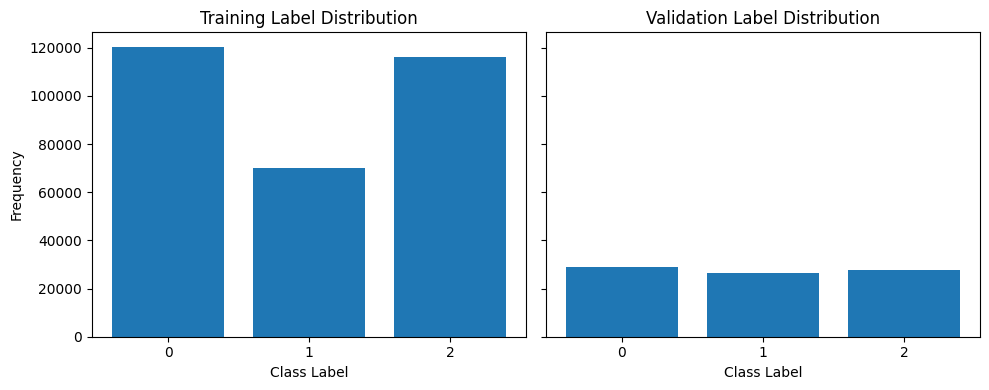

In [16]:
y_train = dataset_train.y.numpy()
y_val = dataset_val.y.numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Training labels
axes[0].hist(y_train, bins=np.arange(-0.5, 3.5, 1), rwidth=0.8)
axes[0].set_title("Training Label Distribution")
axes[0].set_xlabel("Class Label")
axes[0].set_ylabel("Frequency")
axes[0].set_xticks([0, 1, 2])

# Validation labels
axes[1].hist(y_val, bins=np.arange(-0.5, 3.5, 1), rwidth=0.8)
axes[1].set_title("Validation Label Distribution")
axes[1].set_xlabel("Class Label")
axes[1].set_xticks([0, 1, 2])

plt.tight_layout()
plt.show()

In [80]:
from models.deepLOB.deepLOB_model import Deeplob
from torchinfo import summary

model = Deeplob(lighten=lighten)
model.to(model.device)
summary(model, (1, 1, 100, feature_size))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 2, LeakyReLU: 2]

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
from tqdm import tqdm
from datetime import datetime

def batch_gd(model_id, model, criterion, optimizer, train_loader, val_loader, epochs, name):
    training_info = {
        'train_loss_hist': [],
        'val_loss_hist': [],
        'train_acc_hist': [],
        'val_acc_hist': []
    }

    best_test_loss = np.inf
    best_test_epoch = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    for iter in tqdm(range(epochs)):
        model.train()
        t0 = datetime.now()
        train_loss = []
        train_acc = []
        for inputs, targets in tqdm(train_loader):
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim = 1) == targets).item()/targets.size(0)
            train_acc.append(tmp_acc)
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)

        model.eval()
        val_loss = []
        val_acc = []
        for inputs, targets in tqdm(val_loader):
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
            tmp_acc = torch.count_nonzero(torch.argmax(outputs, dim=1) == targets).item() / targets.size(0)
            val_acc.append(tmp_acc)
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)

        # Save losses
        training_info['train_loss_hist'].append(train_loss)
        training_info['val_loss_hist'].append(val_loss)
        training_info['train_acc_hist'].append(train_acc)
        training_info['val_acc_hist'].append(val_acc)

        if val_loss < best_test_loss:
            # torch.save(model, os.path.join(logger.find_save_path(model_id), 'best_val_model.pt'))
            best_test_loss = val_loss
            best_test_epoch = iter
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {iter + 1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc: .4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc: .4f}, '
              f'Duration: {dt}, Best Val Epoch: {best_test_epoch}')

    # torch.save({
    #     'epoch': epochs,
    #     'model_state_dict': model.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': train_loss,
    # }, os.path.join(logger.find_save_path(model_id), 'checkpoint.pt'))

    # with open(os.path.join(logger.find_save_path(model_id), 'training_process.pkl'), 'wb') as f:
    #     pickle.dump(training_info, f)

    return


In [52]:
model_id = 'test_2'
batch_gd(model_id = model_id, model = model, criterion = criterion, optimizer = optimizer,
         train_loader = train_loader, val_loader = val_loader, epochs=epoch, name = model.name)

  0%|                                                                                                        | 0/30 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [24]:
from models.deepLOB.evaluate import evaluate

evaluate.test(model_id=model_id, model_type=model_type)
# classification_report.report(model_id=model_id)
# training_vis.vis_training_process(model_id=model_id)

ModuleNotFoundError: No module named 'loaders'

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

all_midprices = dataset_test.get_midprice()
all_targets = []
all_predictions = []

for inputs, targets in tqdm(test_loader):
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    max_output, predictions = torch.max(outputs, 1)

    # update counts
    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_predictions = np.concatenate(all_predictions)

# with open(os.path.join(logger.find_save_path(model_id), 'prediction.pkl'), 'wb') as f:
#     pickle.dump([all_midprices, all_targets, all_predictions], f)

test_acc = accuracy_score(all_targets, all_predictions)
print(f"Test acc: {test_acc:.4f}")
print(classification_report(all_targets, all_predictions, digits=4))
print(confusion_matrix(all_targets, all_predictions))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:04<00:00, 140.34it/s]

Test acc: 0.6259
              precision    recall  f1-score   support

           0     0.6170    0.5906    0.6035     29147
           1     0.7812    0.6163    0.6890     26310
           2     0.5397    0.6724    0.5988     27662

    accuracy                         0.6259     83119
   macro avg     0.6460    0.6264    0.6304     83119
weighted avg     0.6432    0.6259    0.6290     83119

[[17213  2390  9544]
 [ 3775 16214  6321]
 [ 6909  2152 18601]]


In [ ]:
# from utils.fi2010_loader import __vis_sample_lob__
# __vis_sample_lob__('DecPre')

In [25]:
model_transLOB = TransLOB(
    num_features=feature_size,
    num_classes=3,
    hidden_channels=14,
    d_model=64,
    num_heads=4,
    num_transformer_blocks=2
).to(device)
summary(model_transLOB, (1, 100, feature_size))

Layer (type:depth-idx)                   Output Shape              Param #
TransLOB                                 [1, 3]                    --
├─LOBFeatureExtractor: 1-1               [1, 100, 14]              --
│    └─Conv1d: 2-1                       [1, 14, 100]              1,134
│    └─Conv1d: 2-2                       [1, 14, 100]              406
│    └─Conv1d: 2-3                       [1, 14, 100]              406
│    └─Conv1d: 2-4                       [1, 14, 100]              406
│    └─Conv1d: 2-5                       [1, 14, 100]              406
├─LayerNorm: 1-2                         [1, 100, 14]              28
├─LOBPositionalEncoding: 1-3             [1, 100, 15]              --
├─Linear: 1-4                            [1, 100, 64]              1,024
├─LOBTransformerBlock: 1-5               [1, 100, 64]              --
│    └─MultiheadAttention: 2-6           [1, 100, 64]              16,640
│    └─LayerNorm: 2-7                    [1, 100, 64]              128


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_transLOB.parameters(), lr=learning_rate)

# batch_gd(model_id = 'test3', model = model2, criterion = criterion, optimizer = optimizer,
#          train_loader = train_loader, val_loader = val_loader, epochs=epoch, name = "transLOB")

In [38]:
from utils.training import train, validate

learning_rate= 1e-4
epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(model_transLOB, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model_transLOB, val_loader, criterion, device)
    # val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f} | "
          f"Val Loss {val_loss:.4f} | Val Acc {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_transLOB.state_dict(), './outputs/transLOB/best_transLOB_fi2010.pth')
        print(f"✅ Saved best model at epoch {epoch+1} with Val Acc {val_acc:.4f}")

[Batch 0/2393] Train Loss: 0.9703 | Train Accuracy: 0.5156
[Batch 500/2393] Train Loss: 0.9806 | Train Accuracy: 0.4609
[Batch 1000/2393] Train Loss: 0.8457 | Train Accuracy: 0.6094
[Batch 1500/2393] Train Loss: 0.9830 | Train Accuracy: 0.5000
[Batch 2000/2393] Train Loss: 0.9331 | Train Accuracy: 0.4766
Epoch 1/20: Train Loss 0.9367 | Train Acc 0.5224 | Val Loss 0.9632 | Val Acc 0.5135
✅ Saved best model at epoch 1 with Val Acc 0.5135
[Batch 0/2393] Train Loss: 0.9670 | Train Accuracy: 0.4609
[Batch 500/2393] Train Loss: 0.8502 | Train Accuracy: 0.5625
[Batch 1000/2393] Train Loss: 0.9382 | Train Accuracy: 0.5469
[Batch 1500/2393] Train Loss: 0.9054 | Train Accuracy: 0.5781
[Batch 2000/2393] Train Loss: 0.8906 | Train Accuracy: 0.5703
Epoch 2/20: Train Loss 0.8987 | Train Acc 0.5467 | Val Loss 0.9402 | Val Acc 0.5257
✅ Saved best model at epoch 2 with Val Acc 0.5257
[Batch 0/2393] Train Loss: 0.8455 | Train Accuracy: 0.5156
[Batch 500/2393] Train Loss: 0.8817 | Train Accuracy: 0.5625


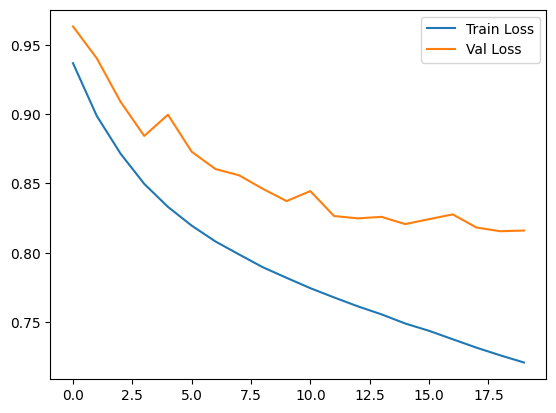

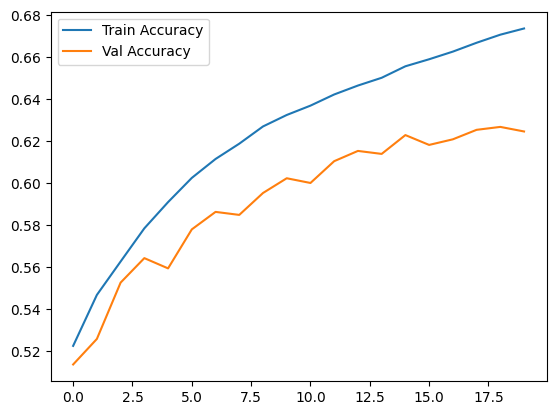

In [40]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

In [41]:
model.eval()

all_y_true = []
all_y_pred = []

with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, y_pred = outputs.max(1)

        all_y_true.append(y_batch.cpu().numpy())
        all_y_pred.append(y_pred.cpu().numpy())

all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)

cm = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix on Test Set")
plt.show()

accuracy = accuracy_score(all_y_true, all_y_pred)
precision = precision_score(all_y_true, all_y_pred, average='macro')
recall = recall_score(all_y_true, all_y_pred, average='macro')
f1 = f1_score(all_y_true, all_y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (macro): {precision:.4f}")
print(f"Test Recall (macro): {recall:.4f}")
print(f"Test F1 Score (macro): {f1:.4f}")

NameError: name 'model' is not defined